In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving operational_log.csv to operational_log.csv
User uploaded file "operational_log.csv" with length 861783 bytes


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly
import seaborn as sns

In [27]:
data = pd.read_csv('operational_log.csv')
data.head()

,response_time,event_start_ms,event_start_epoc,year,month,day
0,8.674542,564,1544956946,2018,12,16
1,8.994416,388,1544956946,2018,12,16
2,10.833192,493,1544956945,2018,12,16
3,18.026684,315,1544956945,2018,12,16
4,10.089430,32,1544956945,2018,12,16


In [28]:
data['dateInt']=data['year'].astype(str) + data['month'].astype(str).str.zfill(2)+ data['day'].astype(str).str.zfill(2)
data['Date'] = pd.to_datetime(data['dateInt'], format='%Y%m%d')
data.head(6)

,response_time,event_start_ms,event_start_epoc,year,month,day,dateInt,Date
0,8.674542,564,1544956946,2018,12,16,20181216,2018-12-16
1,8.994416,388,1544956946,2018,12,16,20181216,2018-12-16
2,10.833192,493,1544956945,2018,12,16,20181216,2018-12-16
3,18.026684,315,1544956945,2018,12,16,20181216,2018-12-16
4,10.089430,32,1544956945,2018,12,16,20181216,2018-12-16
5,17.436021,975,1544956944,2018,12,16,20181216,2018-12-16


In [29]:
data.to_csv('data.csv')

In [49]:
data = pd.read_csv('data.csv', index_col='Date', parse_dates=True)
data.tail()

,Unnamed: 0,response_time,event_start_ms,event_start_epoc,year,month,day,dateInt
Date,,,,,,,,
2018-11-24,19995,22.582991,41,1543092208,2018,11,24,20181124
2018-11-24,19996,822.168564,64,1543092206,2018,11,24,20181124
2018-11-24,19997,9.834566,19,1543092208,2018,11,24,20181124
2018-11-24,19998,11.340903,673,1543092207,2018,11,24,20181124
2018-11-24,19999,9.042504,71,1543092207,2018,11,24,20181124


In [17]:
!pip install chart_studio

     |████████████████████████████████| 71kB 3.4MB/s 


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import chart_studio.plotly as py
import plotly.graph_objs as go

In [50]:
#aggregating, frequencing, sorting the data and filling empty values of the dataset by 0

data = data.groupby(by = 'Date').agg({'response_time':'count'})
data.index = pd.to_datetime(data.index)
data = data.asfreq(freq='1D')
data = data.sort_values(by="Date")
data['response_time'] = data['response_time'].fillna(0)
display(data.tail())

,response_time
Date,
2019-03-22,0.0
2019-03-23,0.0
2019-03-24,0.0
2019-03-25,240.0
2019-03-26,264.0


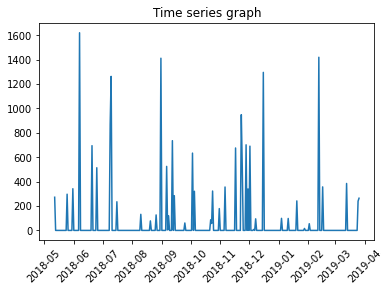

<Figure size 7200x720 with 0 Axes>

In [51]:
f, ax = plt.subplots(1,1)
ax.plot(data['response_time'])

ax.set_title('Time series graph')

ax.tick_params(axis='x', rotation = 45)
plt.figure(figsize=(100,10))
plt.show()
plt.close()

In [52]:
#SARIMA stands for Seasonal (S) Auto-Regressive (AR) Integrated (I) Moving Average (MA). 
#The Seasonal ARIMA model is to difference the series to make it stationary by taking differences of the variable over time. 
#There are 3 methods to take differences in an ARIMA model - AR, I, and MA.
#I is a full difference. That is today’s value minus yesterday’s value.
#AR is very much related. The way that I like to think of the AR term is that it is a partial difference. The coefficient on the AR term will tell you the percent of a difference you need to take.
#MA is what percent to add back into the error term after differencing. 
#Greene’s book Econometric Analysis, makes the point that this is really about patching up the standard errors. 


from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model
model = SARIMAX(data, order=(1, 0, 0), seasonal_order=(1, 1, 0, 7))

# Fit the model
results = model.fit()

# Print the results summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                     response_time   No. Observations:                  319
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood               -2187.206
Date:                           Mon, 04 Jan 2021   AIC                           4380.413
Time:                                   00:49:12   BIC                           4391.642
Sample:                               05-12-2018   HQIC                          4384.901
                                    - 03-26-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0004      0.058     -0.008      0.994      -0.114       0.113
ar.S.L7       -0.5046      0.021    -23.535      0.000      -0.547      -0.463
sigma2      7.148e+04   2291.532     31.192      0.000     6.7e+04     7.6e+04
===================================================================================
Ljung-Box (Q):                       64.98   Jarque-Bera (JB):              1628.83
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             1.74
Prob(H) (two-sided):                  0.03   Kurtosis:                        13.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
results.specification

{'concentrate_scale': False,
 'enforce_invertibility': True,
 'enforce_stationarity': True,
 'hamilton_representation': False,
 'k_ar': 1,
 'k_ar_params': 1,
 'k_diff': 0,
 'k_exog': 0,
 'k_ma': 0,
 'k_ma_params': 0,
 'k_seasonal_ar': 7,
 'k_seasonal_diff': 1,
 'k_seasonal_ma': 0,
 'k_trend': 0,
 'measurement_error': False,
 'mle_regression': False,
 'order': (1, 0, 0),
 'seasonal_order': (1, 1, 0, 7),
 'seasonal_periods': 7,
 'simple_differencing': False,
 'state_regression': False,
 'time_varying_regression': False,
 'trend': None}

In [54]:
# Create SARIMA mean forecast
sarima_pred = results.get_forecast(30)
sarima_mean = sarima_pred.predicted_mean
sarima_mean.head(7)

2019-03-27    1.941414e+02
2019-03-28    5.037319e-05
2019-03-29   -2.200377e-08
2019-03-30    9.611583e-12
2019-03-31   -4.193150e-15
2019-04-01    1.189049e+02
2019-04-02    1.307954e+02
Freq: D, dtype: float64

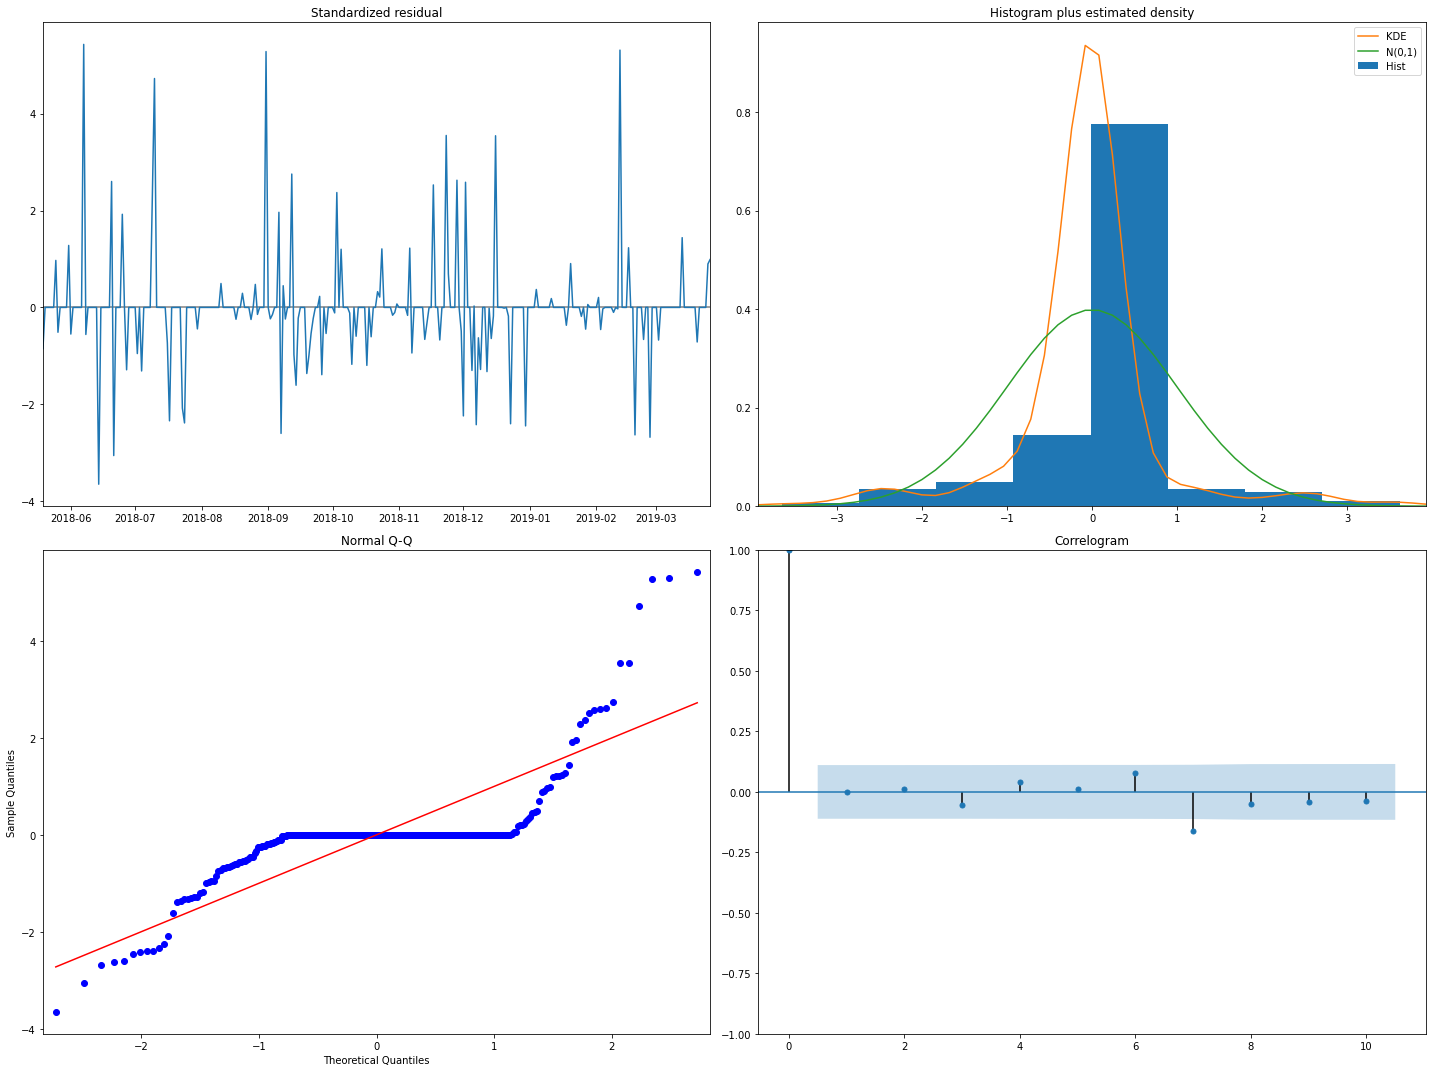

In [55]:
# Plot common diagnostics
results.plot_diagnostics(figsize=(20, 15));
plt.tight_layout();

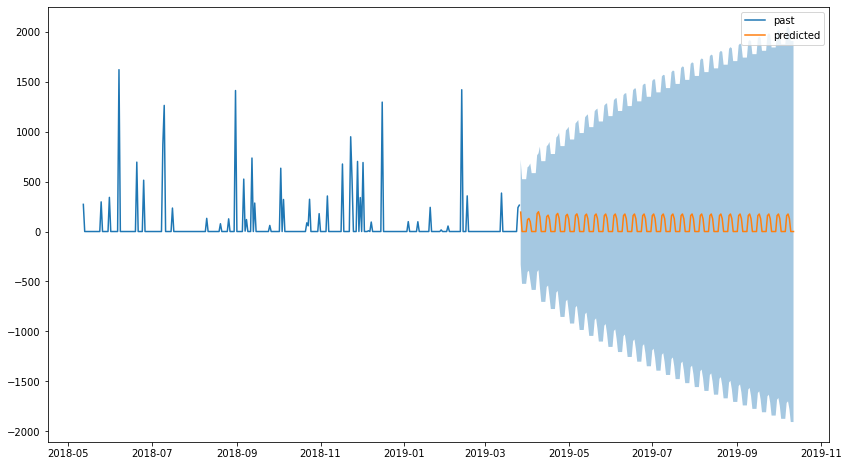

In [59]:
# Create forecast object
forecast_object = results.get_forecast(200)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

plt.figure(figsize= (14,8))

# Plot past response time
plt.plot(data.index, data, label='past');

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted');

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.loc[:, 'lower response_time'], 
                 conf_int.loc[:, 'upper response_time'], alpha=0.4, );

# Plot legend
plt.legend();

In [63]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline


# Importing everything

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(data, 24) # prediction for the last observed day (past 24 hours)

37.041666666666664

In [65]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


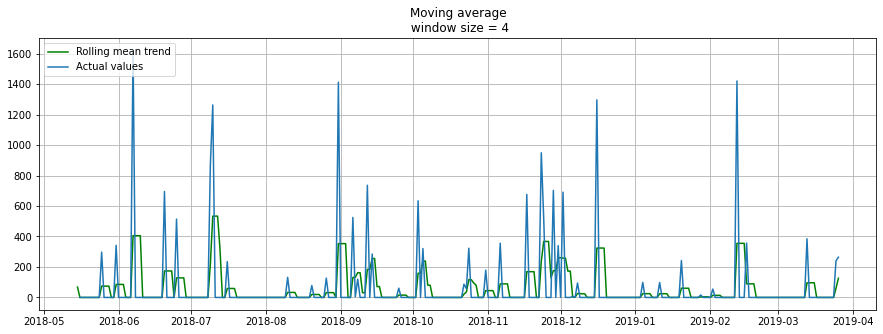

In [66]:
#Let's smooth by the previous 4 hours.

plotMovingAverage(data, 4) 

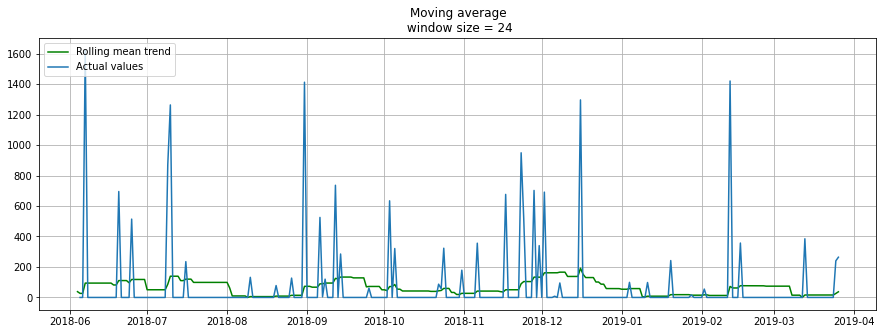

In [67]:
plotMovingAverage(data, 24)

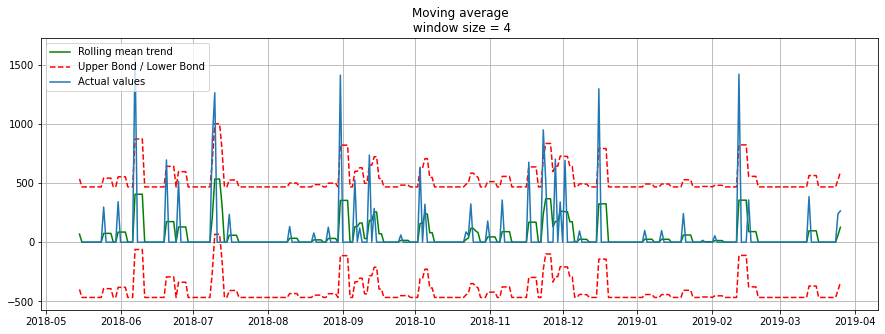

In [68]:
plotMovingAverage(data, 4, plot_intervals=True)


In [69]:
data_anomaly = data.copy()
data_anomaly.iloc[-20] = data_anomaly.iloc[-20] * 0.2 # say we have 80% drop of response time 

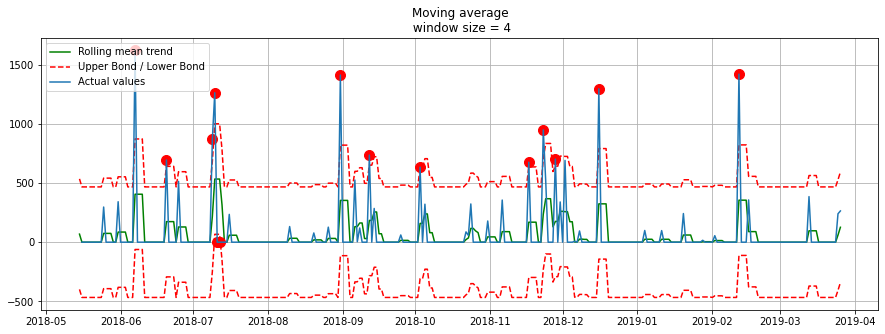

In [71]:
plotMovingAverage(data_anomaly, 4, plot_intervals=True, plot_anomalies=True) #let's see how it catches anomalies

In [72]:
#nice! trying weighted average now.Weighted average is a simple modification to the moving average.
# The weights sum up to 1 with larger weights assigned to more recent observations.

def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [73]:
weighted_average(data, [0.6, 0.3, 0.1])

98.4

In [74]:
#Now, let's see what happens if, instead of weighting the last  k  values of the time series, 
#we start weighting all available observations while exponentially decreasing the weights as we move further back in time. 
#There exists a formula for exponential smoothing that will help us with this

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [75]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

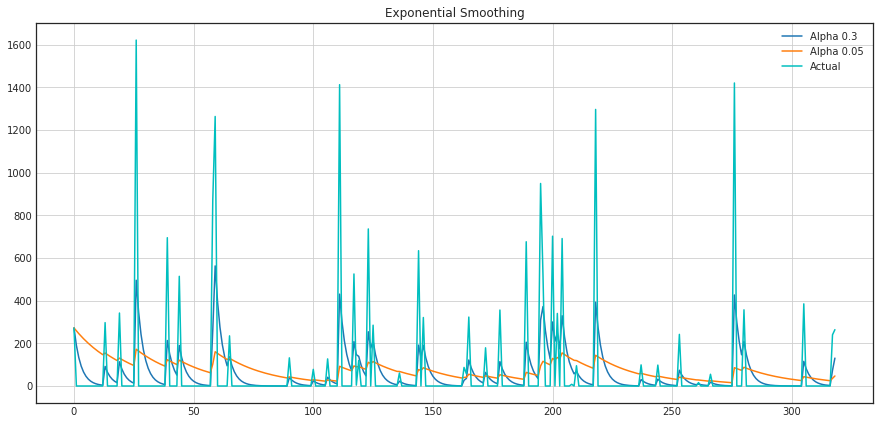

In [76]:
plotExponentialSmoothing(data.response_time, [0.3, 0.05])

In [77]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)


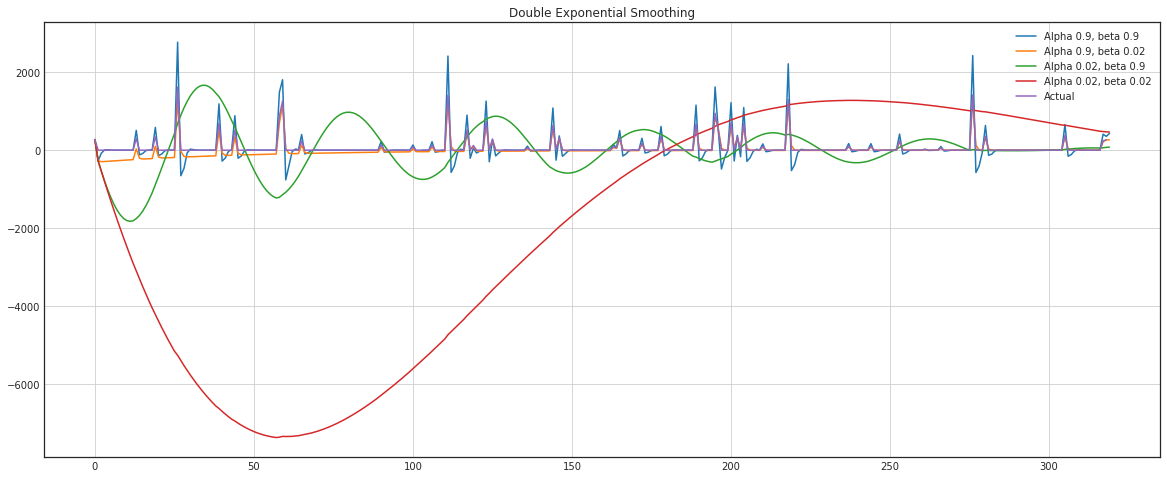

In [78]:
plotDoubleExponentialSmoothing(data.response_time, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [84]:
#Time series plot

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


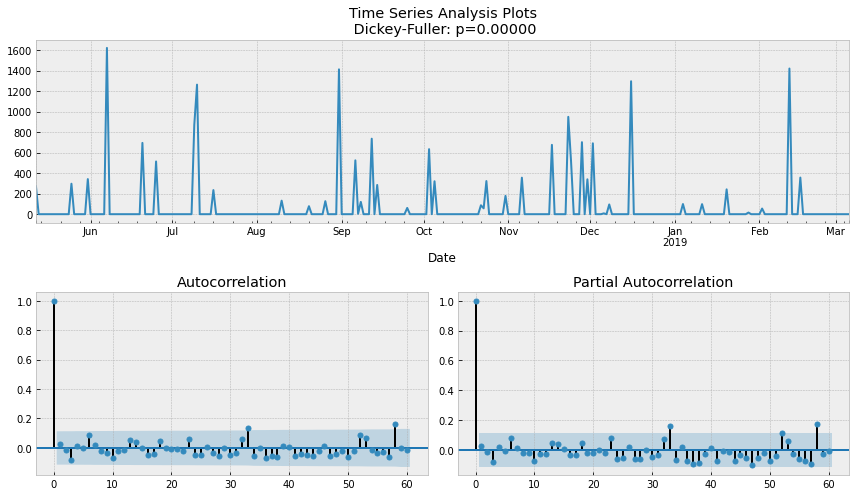

In [87]:
tsplot(data, lags=60)

In [91]:
#SARIMA

# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [108]:
#divide into train and validation set
train = data[:int(0.7*(len(data)))]

valid = data[int(0.7*(len(data))):]

In [111]:
import itertools  
import sys

# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

seasonal = 52
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

In [113]:

# compute the Akaike Information Criterion (AIC): choose the model with lowest AIC.
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)
            
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        
        except:
            print(param,param_seasonal, "Unexpected error:", sys.exc_info()[1])
            continue
            
            
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

(0, 0, 0) (1, 1, 1, 52) Unexpected error: Schur decomposition solver error.
(0, 1, 0) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 1, 0) (1, 0, 1, 52) Unexpected error: LU decomposition error.
(0, 1, 0) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 1, 1) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 1, 1) (1, 0, 1, 52) Unexpected error: LU decomposition error.
(0, 1, 1) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 0) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 0) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 1) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 1) (1, 0, 1, 52) Unexpected error: LU decomposition error.
(1, 1, 1) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
Best SARIMAX(0, 1, 1)x(1, 1, 0, 52)12 model - AIC:2214.891679892632


In [114]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(train,
                                order=(0,1,1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
res = mdl.fit()

# print statistics
print(res.aic)
print(res.summary())

2214.891679892632
                                 Statespace Model Results                                 
Dep. Variable:                      response_time   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 52)   Log Likelihood               -1104.446
Date:                            Mon, 04 Jan 2021   AIC                           2214.892
Time:                                    02:51:01   BIC                           2224.041
Sample:                                05-12-2018   HQIC                          2218.608
                                     - 12-06-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0526      0.052    -20.302      0.000      -1.154      -0.951
ar.S.L52      -0.

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower than 0.01, so it is reasonable to retain all of them in our model. The Ljung-Box Q statistic is used to test the $H_0$ that the complete data set is independently distributed, i.e. not serially correlated. 

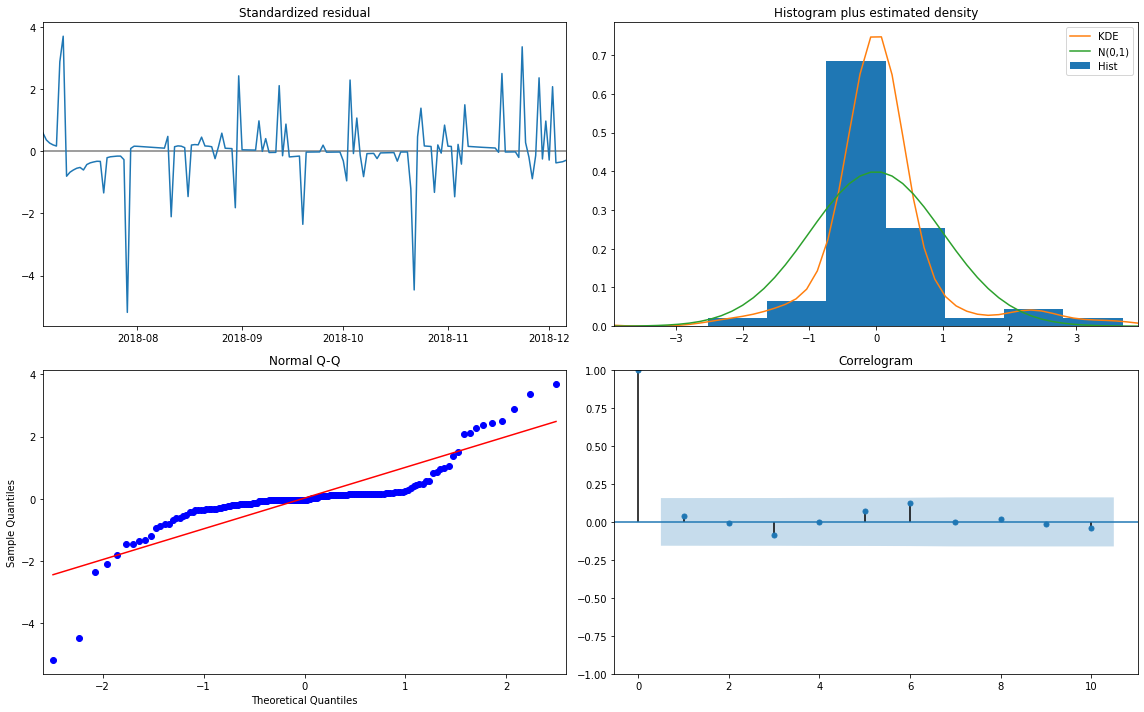

In [116]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

In [117]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

In [120]:
pred2 = res.get_prediction(start=mid, end=mid+len(valid)-1)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      response_time   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 52)   Log Likelihood               -1104.446
Date:                            Mon, 04 Jan 2021   AIC                           2214.892
Time:                                    03:00:14   BIC                           2224.041
Sample:                                05-12-2018   HQIC                          2218.608
                                     - 12-06-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0526      0.052    -20.302      0.000      -1.154      -0.951
ar.S.L52      -0.3832      0.045   

ACF and PACF of residuals


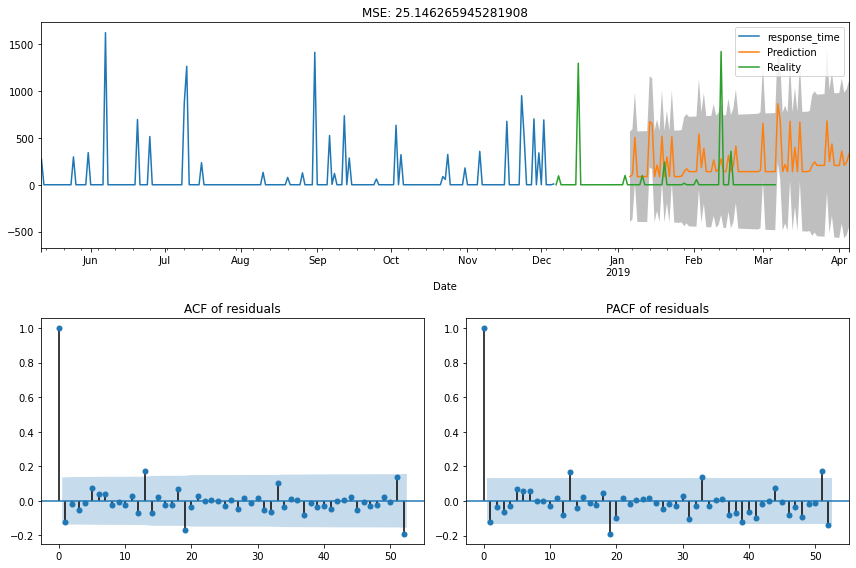

In [122]:
def plotSARIMAX_m(train_data, test_data, pred_model):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    train_data.plot(ax=ax1);
    t = 'MSE: {}'.format(mean_squared_log_error(test_data,pred_model.predicted_mean))
    pred_model.predicted_mean.plot(ax=ax1, title=t, label = 'Prediction')
    test_data.plot(ax=ax1, label = 'Reality')
    ax1.fill_between(pred_model.conf_int(alpha = 0.1).index, 
                     pred_model.conf_int(alpha = 0.1).iloc[:,0], 
                     pred_model.conf_int(alpha = 0.1).iloc[:,1], 
                     alpha=0.5,facecolor='grey')
    ax3 = sm.graphics.tsa.plot_acf(res.resid, lags=seasonal, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(res.resid, lags=seasonal, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    ax1.legend()
    print("ACF and PACF of residuals")
    
plotSARIMAX_m(train, valid, pred2)

In [131]:
#Choosing appropriate alfa

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def accuracy(test_data, model, alpha=0.05):
    a = 0
    anomly = list()
    for i in range(len(test_data)):
        if (test_data[i] >=  model.conf_int(alpha = alpha).iloc[i,0] 
            and test_data[i] <=  model.conf_int(alpha = alpha).iloc[i,1]): 
            a += 1
        else: anomly.append([str(test_data.index[i]), test_data[i]])
  
    return round(a/len(test_data),4), anomly
    
def compare_acc(test_data, model, range_start, range_end, range_sep):
    alpha = np.arange(range_start,range_end, range_sep)
    acc = pd.DataFrame(columns = ['alpha','acc','no_of_ab'])
    acc["alpha"] = alpha
    for i in range(len(alpha)):
        acc.iloc[i,1] = accuracy(test_data, model, alpha=alpha[i])[0]
        acc.iloc[i,2] = len(accuracy(test_data, model, alpha=alpha[i])[1])
        
    data = [
        go.Scatter(
            x=acc.alpha, # assign x as the dataframe column 'x'
            y=acc.acc,
            name ='Accuracy'
        ),
        go.Scatter(
            x=acc.alpha,
            y=acc.no_of_ab,
            name = 'The number of abnomal date',
            yaxis='y2'
        )
    ]
    
    layout = go.Layout(
    title='Accuracy comparison based on different Alpha',
    yaxis=dict(
        title='Accuracy'
    ),
    yaxis2=dict(
        title='Abnormal Date',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
    fig = go.Figure(data=data, layout=layout)
    return fig.show()

compare_acc(valid, pred2,0.01,0.2,0.01)

In [205]:

def hightlight(alpha, test_data = valid, model = pred2):
    anomly_date = accuracy(test_data, model, alpha=alpha)[1]
    anomly = pd.DataFrame(columns = ['alpha','anomly_date','anomly_y'])
    anomly['org'] = anomly_date[:]
    for i in range(len(anomly_date)):
        anomly.iloc[i,0] = alpha
        anomly.iloc[i,1] = anomly.iloc[i,3][0]
        anomly.iloc[i,2] = anomly.iloc[i,3][1]
    return anomly

import random
def random_color():
    r = random.randint(50,255)
    g = random.randint(50,255)
    b = random.randint(50,255)
    return (r,g,b)

def areaplot(alpha):
    color = random_color()
    trace0 = go.Scatter(
        x=pred2.conf_int(alpha=alpha).index,
        y=pred2.conf_int(alpha=alpha).iloc[:,1],
        fill= None,
        mode='lines',
        showlegend=False,
        name='Upper Bound',
        line=dict(width=0.5,
                  color='rgba({},{},{},{})'.format(color[0],color[1],color[2],0.5)
        ))
    trace1 = go.Scatter(
        x=pred2.conf_int(alpha=alpha).index,
        y= pred2.conf_int(alpha=alpha).iloc[:,0],
        fill='tonexty',
        mode='lines',
        line=dict(width=0.5,
                  color='rgba({},{},{},{})'.format(color[0],color[1],color[2],0.5)),
        name = 'alpha = {}'.format(alpha)
        )
    trace2 = go.Scatter(
        x=valid.index, # assign x as the dataframe column 'x'
        y=valid,
        name = 'Real data',
        line=dict(color='rgb{}'.format(color)),
        mode='lines')

    trace3 = go.Scatter(
        x = hightlight(alpha).anomly_date,
        y = hightlight(alpha).anomly_y,
        name = 'Alert points',
        hoverinfo='none',
        mode = 'markers'
    )


    Data = [trace0, trace1, trace2, trace3]

    return py.iplot(Data, filename= 'Area Plot for different alfa')
##rgb(255,253,180),'rgb(255,216,55)'

In [206]:

areaplot(0.01)

PlotlyRequestError: ignored

In [180]:
areaplot(0.05)

In [ ]:
areaplot(0.15)